In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from matplotlib import pyplot as plt
from collections import defaultdict
import random
import string

import time
import re
from tqdm import tqdm

import pandas as pd
import ast
import time
from tqdm import tqdm
from gensim.models import Word2Vec

In [2]:
"""
Parameters
"""
GROUP_SIZE = 1  # Number of years in each time period

"""
Word2Vec hyperparameters
"""
EMBEDDING_SIZE = 50
WINDOW = 5
EPOCHS = 10
MIN_COUNT = 1
SG = 1
NEGATIVE_SAMPLES = 10


path = 'data/sample/diachronic_dump_sample.csv'
df = pd.read_csv(path)
df["article"] = df["lemma_pos"].apply(eval)


# Group by time periods
def get_period(year, group_size):
    start = year - (year % group_size)
    end = start + group_size - 1
    return f"{start}-{end}"

df['period'] = df['year'].apply(lambda y: get_period(y, GROUP_SIZE))
dfs = {period: group.reset_index(drop=True) for period, group in df.groupby('period')}
print(f"Prepared {len(dfs)} grouped time slices (every {GROUP_SIZE} years).")

class LossLogger:
    def __init__(self):
        self.loss_previous_step = 0

    def log(self, model, epoch):
        loss = model.get_latest_training_loss()
        current_loss = loss - self.loss_previous_step
        self.loss_previous_step = loss
        return current_loss


# Word2Vec training
models = {}
print("Training Word2Vec models by grouped time period...")

total_steps = len(dfs) * EPOCHS
progress_bar = tqdm(total=total_steps, desc="Training", dynamic_ncols=True)

for period, df_ in dfs.items():
    # Flatten all articles into a single list of sentences
    sentences = [sentence for article in df_["article"] for sentence in article]

    model = Word2Vec(vector_size=EMBEDDING_SIZE,
                     window=WINDOW,
                     min_count=MIN_COUNT,
                     workers=16,
                     sg=SG,
                     negative=NEGATIVE_SAMPLES,
                     sample=1e-4,
                     compute_loss=True)

    model.build_vocab(sentences)
    logger = LossLogger()

    for epoch in range(EPOCHS):
        model.train(sentences,
                    total_examples=model.corpus_count,
                    epochs=1)
        loss = logger.log(model, epoch)
        progress_bar.set_description(f"{period} | Epoch {epoch+1}/{EPOCHS}")
        progress_bar.set_postfix(loss=f"{loss:.2f}")
        progress_bar.update(1)

    models[period] = model

progress_bar.close()

Prepared 14 grouped time slices (every 1 years).
Training Word2Vec models by grouped time period...


2024-2024 | Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:17<00:00,  7.91it/s, loss=0.00]


In [3]:
"""
Alignment functions
"""

def intersection_align_gensim(m1, m2):
    common = list(set(m1.wv.key_to_index).intersection(set(m2.wv.key_to_index)))
    common.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)

    def align_model(model):
        vectors = np.array([model.wv[w] for w in common])
        model.wv.vectors = vectors
        model.wv.key_to_index = {w: i for i, w in enumerate(common)}
        model.wv.index_to_key = common
        return model

    return align_model(m1), align_model(m2)

def smart_procrustes_align_gensim(base, other):
    base, other = intersection_align_gensim(base, other)
    m = other.wv.vectors.T @ base.wv.vectors
    u, _, v = np.linalg.svd(m)
    ortho = u @ v
    other.wv.vectors = other.wv.vectors @ ortho
    return other


def cosine_distance(a, b):
    return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

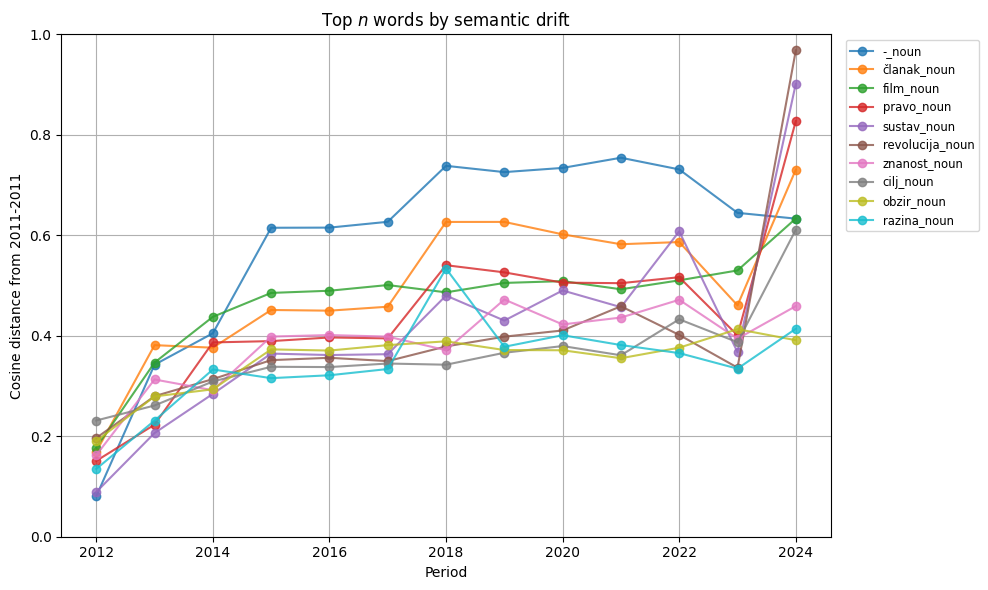

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine as cosine_distance
from collections import Counter

TOP_N = 10

def period_key(p):
    return int(p.split("-")[0])  # extract starting year

periods = sorted(models.keys(), key=period_key)

for i in reversed(range(1, len(periods))):
    models[periods[i - 1]] = smart_procrustes_align_gensim(models[periods[i]], models[periods[i - 1]])

"""
Semantic drift scores
"""
# Step 1: Identify shared vocabulary
vocab_sets = [set(model.wv.index_to_key) for model in models.values()]
common_vocab = set.intersection(*vocab_sets)

# Optional: filter by POS
common_vocab = [w for w in common_vocab if w.endswith("_noun")]

# Step 2: Calculate average cosine distance from base period
base_period = periods[0]
drift_scores = {}

for word in common_vocab:
    base_vec = models[base_period].wv[word]
    distances = []
    for period in periods[1:]:
        vec = models[period].wv[word]
        dist = cosine_distance(base_vec, vec)
        distances.append(dist)
    drift_scores[word] = np.mean(distances)

# Step 3: Select top drifting words
top_drifters = sorted(drift_scores.items(), key=lambda x: x[1], reverse=True)[:TOP_N]


# Plot drift for top words
plt.figure(figsize=(10, 6))

for word, _ in top_drifters:
    dists = [np.nan]  # base period = no change
    for i in range(1, len(periods)):
        try:
            v1 = models[base_period].wv[word]
            v2 = models[periods[i]].wv[word]
            dists.append(cosine_distance(v1, v2))
        except KeyError:
            dists.append(np.nan)
    plt.plot([period_key(p) for p in periods], dists, label=word, marker='o', alpha=0.8)

plt.title("Top $n$ words by semantic drift")
plt.xlabel("Period")
plt.ylabel(f"Cosine distance from {base_period}")
plt.ylim(0, 1)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()